In [1]:
# This is Fine, needs no changes

import numpy as np
import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import math as m
from scipy.stats import norm


def CallOptionValue(S, K, r, sigma, T, q):
    if sigma <= 0 or T <= 0:
        return np.nan, np.nan, np.nan, np.nan, np.nan

    d1 = (m.log(S / K) + (r - q + 0.5 * sigma**2) * T) / (sigma * m.sqrt(T))
    d2 = d1 - sigma * m.sqrt(T)

    price = S * m.exp(-q * T) * norm.cdf(d1) - K * m.exp(-r * T) * norm.cdf(d2)
    delta_call = m.exp(-q * T) * norm.cdf(d1)
    gamma_call = (m.exp(-q * T) * norm.pdf(d1)) / (S * sigma * m.sqrt(T))
    vega_call = S * m.exp(-q * T) * norm.pdf(d1) * m.sqrt(T)
    theta_call = (
        - (S * m.exp(-q * T) * norm.pdf(d1) * sigma) / (2 * m.sqrt(T))
        - r * K * m.exp(-r * T) * norm.cdf(d2)
        + q * S * m.exp(-q * T) * norm.cdf(d1)
    )

    return price, delta_call, gamma_call, vega_call, theta_call


def PutOptionValue(S, K, r, sigma, T, q):
    if sigma <= 0 or T <= 0:
        return np.nan, np.nan, np.nan, np.nan, np.nan

    d1 = (m.log(S / K) + (r - q + 0.5 * sigma**2) * T) / (sigma * m.sqrt(T))
    d2 = d1 - sigma * m.sqrt(T)

    price = K * m.exp(-r * T) * norm.cdf(-d2) - S * m.exp(-q * T) * norm.cdf(-d1)
    delta_put = m.exp(-q * T) * (norm.cdf(d1) - 1)
    gamma_put = (m.exp(-q * T) * norm.pdf(d1)) / (S * sigma * m.sqrt(T))
    vega_put = S * m.exp(-q * T) * norm.pdf(d1) * m.sqrt(T)
    theta_put = (
        - (S * m.exp(-q * T) * norm.pdf(d1) * sigma) / (2 * m.sqrt(T))
        + r * K * m.exp(-r * T) * norm.cdf(-d2)
        - q * S * m.exp(-q * T) * norm.cdf(-d1)
    )

    return price, delta_put, gamma_put, vega_put, theta_put


# Constant Volatility and Interest rate

[*********************100%***********************]  2 of 2 completed


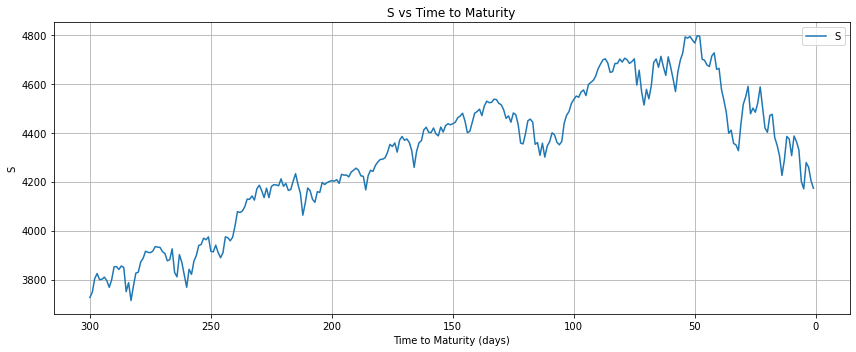

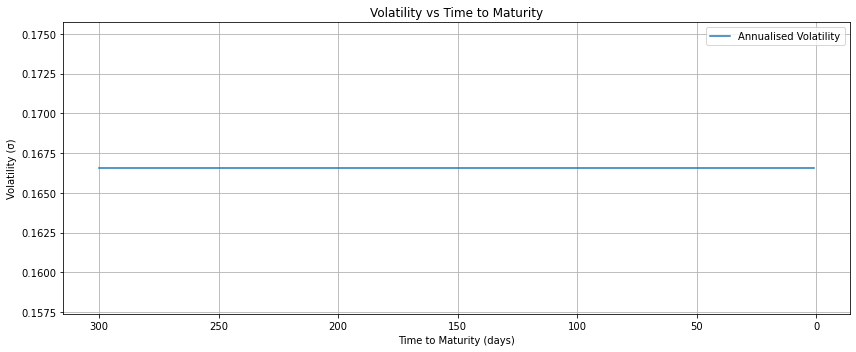

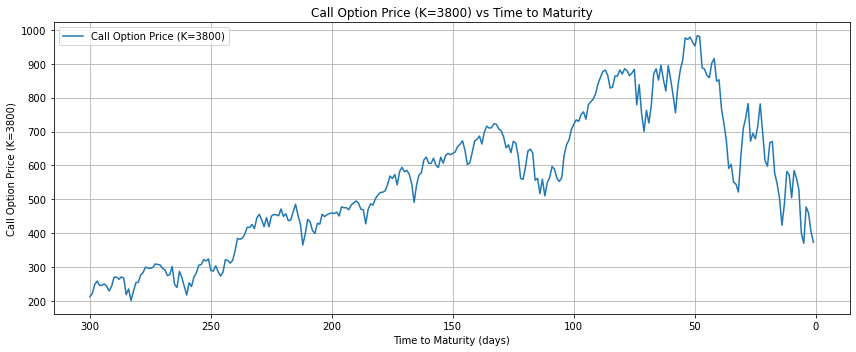

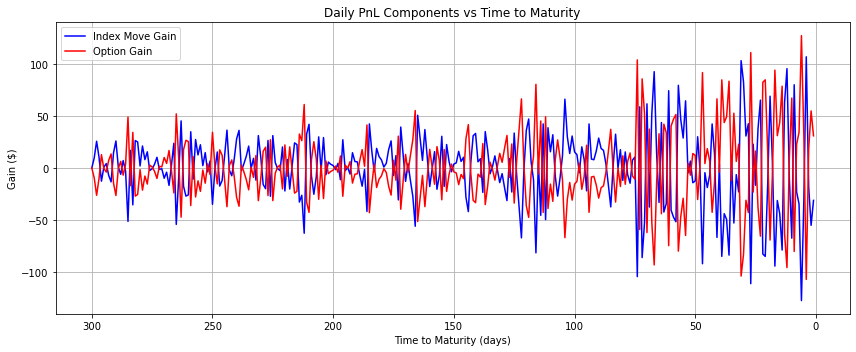

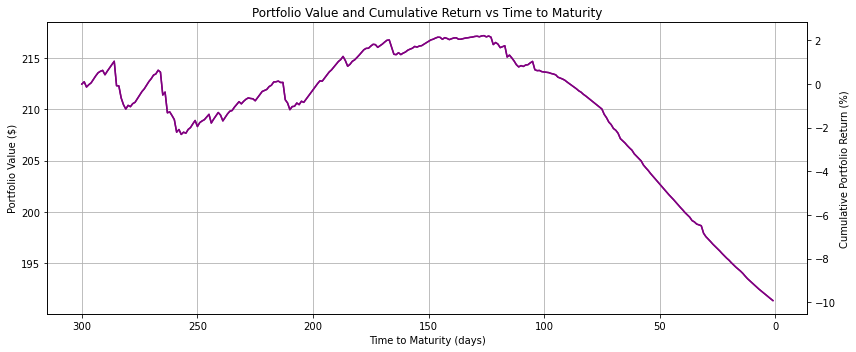

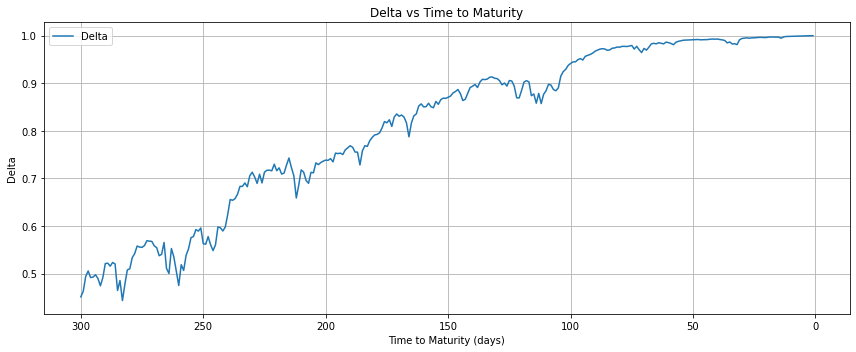

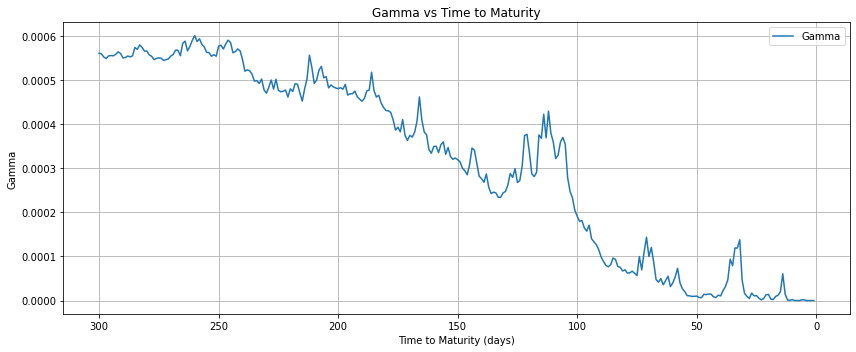

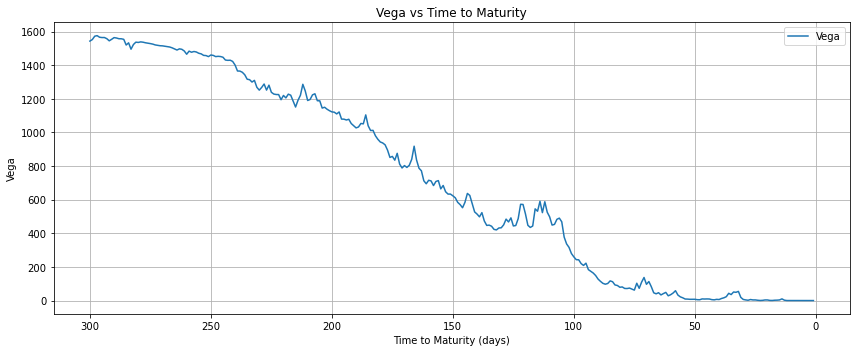

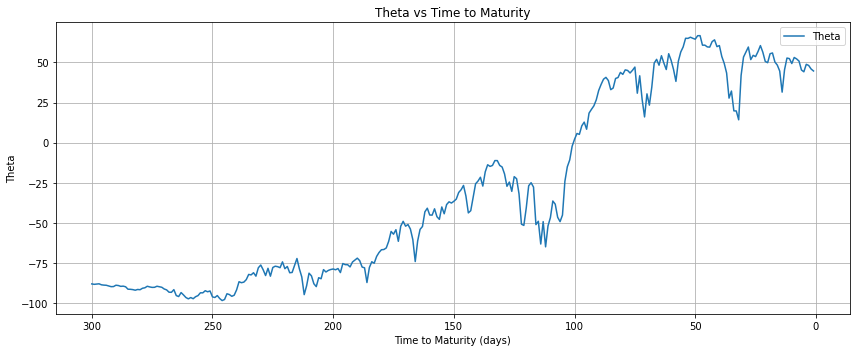

In [68]:

#---------------- All that needs to be decided -------------------------

# Define date range
sim_start = '2021-01-01'
sim_finish = '2028-09-28'


# Choose option type and parameters
Call_or_Put = "Call"
K = 3800
Time_to_maturity = 300
q = 0.04


# S&P 500 and 10-Year Treasury yield (interest rate) 
# Note: Decide on Economy
tickers = ['^GSPC', '^TNX']
data = yf.download(tickers, start=sim_start, end=sim_finish, auto_adjust=True)['Close']
data.rename(columns={'^GSPC': 'S', '^TNX': 'Rate'}, inplace=True)



#-------------------------End------------------------------------------







# --- Compute daily log returns and constant volatility ---
data['S Daily return'] = data['S'].pct_change()
data['S Daily log return'] = np.log(data['S'] / data['S'].shift(1))
data['sigma'] = data['S Daily log return'].std() * np.sqrt(252)

# --- Constant Risk-free rate from 10Y yield, convert % to decimal ---
data['r'] = data['Rate'].mean() / 100 

# --- Set constant dividend yield ---
data['q'] = q

# --- Final tidy up ---
data.drop(columns=['Rate'], inplace=True)
data.dropna(inplace=True)

# --- Ready to use ---
market_returns = data.copy()



# --- Option pricing loop ---
option_prices = []
deltas = []
gammas = []
vegas = []
thetas = []
T_values = []

for i, (index, row) in enumerate(market_returns.iterrows()):
    S = float(row['S'])
    sigma = float(row['sigma'])
    r = float(row['r'])
    q = float(row['q'])

    T_days_remaining = max(Time_to_maturity - i, 0)
    T = T_days_remaining / 252  # time in years

    if Call_or_Put == "Call":
        price, delta, gamma, vega, theta = CallOptionValue(S, K, r, sigma, T, q)
    elif Call_or_Put == "Put":
        price, delta, gamma, vega, theta = PutOptionValue(S, K, r, sigma, T, q)
    else:
        raise ValueError("Invalid option type. Use 'Call' or 'Put'.")

    option_prices.append(price)
    deltas.append(delta)
    gammas.append(gamma)
    vegas.append(vega)
    thetas.append(theta)
    T_values.append(T_days_remaining)

# --- Store results in DataFrame ---
market_returns[f'{Call_or_Put} Option Price (K={K})'] = option_prices
market_returns['Delta'] = deltas
market_returns['Gamma'] = gammas
market_returns['Vega'] = vegas
market_returns['Theta'] = thetas
market_returns['T (days)'] = T_values
market_returns.dropna(inplace=True)





# The bank plans to price and delta-hedge 
#the written options based on Black-Scholes formula.
# i.e we are always short

# Define position
 
initial_option_price = market_returns[f'{Call_or_Put} Option Price (K={K})'].iloc[0]  # we receive premium
    
market_returns['Index Investment ($)'] = market_returns['Delta'] * market_returns['S']  # short delta shares    
market_returns['Daily Gain from index move'] = market_returns['Index Investment ($)'].shift(1)*market_returns['S Daily return']
market_returns['Daily Gain from written option'] = -market_returns[f'{Call_or_Put} Option Price (K={K})'].diff()
market_returns['Daily Portfolio Gain'] = market_returns['Daily Gain from index move'] + market_returns['Daily Gain from written option']
market_returns['Cumulative Portfolio Gain'] = market_returns['Daily Portfolio Gain'].cumsum()

market_returns.fillna(0, inplace=True)
market_returns['Portfolio Value'] = market_returns['Cumulative Portfolio Gain'] + initial_option_price



market_returns['Cumulative Portfolio Return (%)'] = (
    market_returns['Cumulative Portfolio Gain'] / initial_option_price
) * 100


# --- Preview ---


market_returns[['S','S Daily return','sigma', 'r', 'q','T (days)', f'{Call_or_Put} Option Price (K={K})',
                'Delta', 'Index Investment ($)' , 'Daily Gain from index move', 'Daily Gain from written option', 'Daily Portfolio Gain', 'Cumulative Portfolio Gain',
               'Cumulative Portfolio Return (%)']]






plt.figure(figsize=(12, 5))
plt.plot(market_returns['T (days)'], market_returns['S'], label='S')
plt.xlabel('Time to Maturity (days)')
plt.ylabel('S')
plt.title('S vs Time to Maturity')
plt.gca().invert_xaxis()
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()




plt.figure(figsize=(12, 5))
plt.plot(market_returns['T (days)'], market_returns['sigma'], label='Annualised Volatility')
plt.xlabel('Time to Maturity (days)')
plt.ylabel('Volatility (σ)')
plt.title('Volatility vs Time to Maturity')
plt.gca().invert_xaxis()
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



plt.figure(figsize=(12, 5))
plt.plot(market_returns['T (days)'], market_returns[f'{Call_or_Put} Option Price (K={K})'], label=f'{Call_or_Put} Option Price (K={K})')
plt.xlabel('Time to Maturity (days)')
plt.ylabel(f'{Call_or_Put} Option Price (K={K})')
plt.title(f'{Call_or_Put} Option Price (K={K}) vs Time to Maturity')
plt.gca().invert_xaxis()
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()






plt.figure(figsize=(12, 5))
plt.plot(market_returns['T (days)'], market_returns['Daily Gain from index move'], label='Index Move Gain', color='blue')
plt.plot(market_returns['T (days)'], market_returns['Daily Gain from written option'], label='Option Gain', color='red')
plt.title('Daily PnL Components vs Time to Maturity')
plt.xlabel('Time to Maturity (days)')
plt.ylabel('Gain ($)')
plt.legend()
plt.grid(True)
plt.gca().invert_xaxis()  # Optional: shows time progressing left to right
plt.tight_layout()
plt.show()







fig, ax1 = plt.subplots(figsize=(12, 5))

# Plot Portfolio Value on the primary y-axis
color1 = 'purple'
ax1.set_xlabel('Time to Maturity (days)')
ax1.set_ylabel('Portfolio Value ($)', color='black')
ax1.plot(market_returns['T (days)'], market_returns['Portfolio Value'], color=color1, label='Portfolio Value ($)')
ax1.tick_params(axis='y', labelcolor='black')
ax1.invert_xaxis()  # So time moves forward left to right
ax1.grid(True)

# Create secondary y-axis for cumulative return
ax2 = ax1.twinx()
color2 = 'purple'
ax2.set_ylabel('Cumulative Portfolio Return (%)', color='black')
ax2.plot(market_returns['T (days)'], market_returns['Cumulative Portfolio Return (%)'], color=color2, label='Cumulative Portfolio Return (%)')
ax2.tick_params(axis='y', labelcolor='black')

# Add title and layout
plt.title('Portfolio Value and Cumulative Return vs Time to Maturity')
fig.tight_layout()
plt.show()




plt.figure(figsize=(12, 5))
plt.plot(market_returns['T (days)'], market_returns['Delta'], label='Delta')
plt.xlabel('Time to Maturity (days)')
plt.ylabel('Delta')
plt.title('Delta vs Time to Maturity')
plt.gca().invert_xaxis()
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



plt.figure(figsize=(12, 5))
plt.plot(market_returns['T (days)'], market_returns['Gamma'], label='Gamma')
plt.xlabel('Time to Maturity (days)')
plt.ylabel('Gamma')
plt.title('Gamma vs Time to Maturity')
plt.gca().invert_xaxis()
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



plt.figure(figsize=(12, 5))
plt.plot(market_returns['T (days)'], market_returns['Vega'], label='Vega')
plt.xlabel('Time to Maturity (days)')
plt.ylabel('Vega')
plt.title('Vega vs Time to Maturity')
plt.gca().invert_xaxis()
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()




plt.figure(figsize=(12, 5))
plt.plot(market_returns['T (days)'], market_returns['Theta'], label='Theta')
plt.xlabel('Time to Maturity (days)')
plt.ylabel('Theta')
plt.title('Theta vs Time to Maturity')
plt.gca().invert_xaxis()
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()




# Non-constant Volatility and Interest rate violations (reality)

[*********************100%***********************]  2 of 2 completed


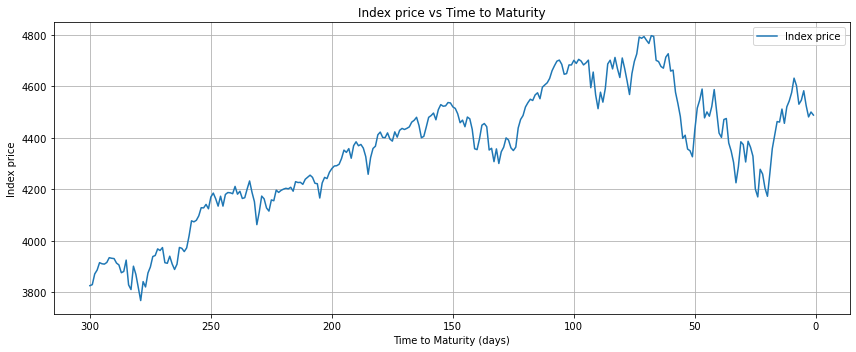

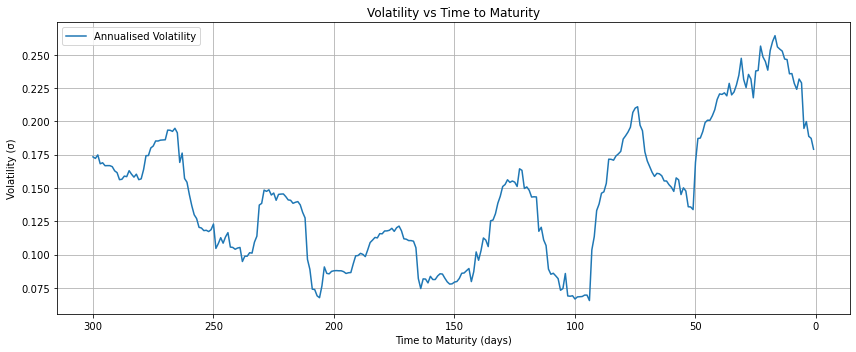

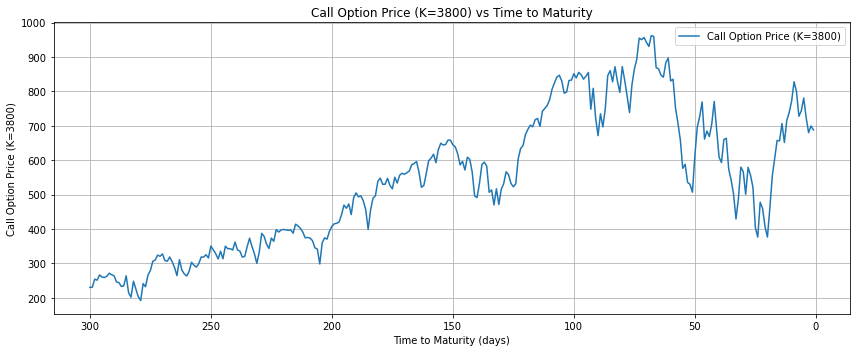

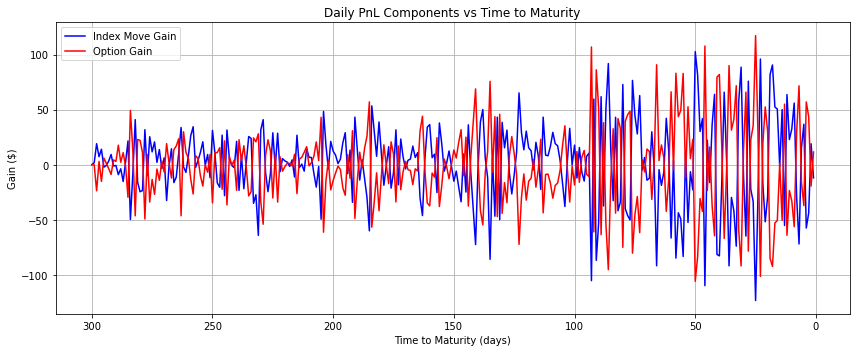

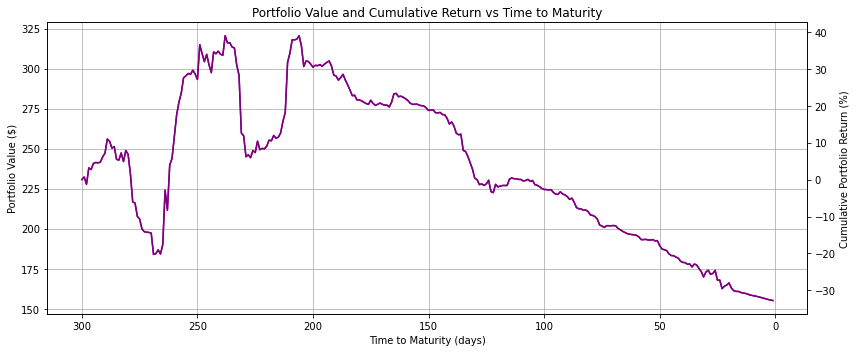

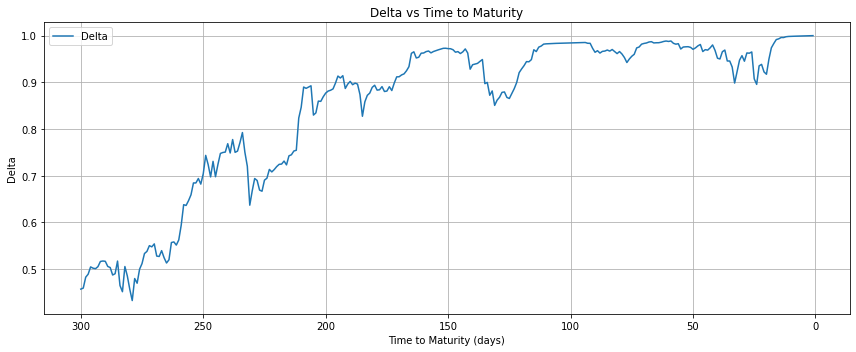

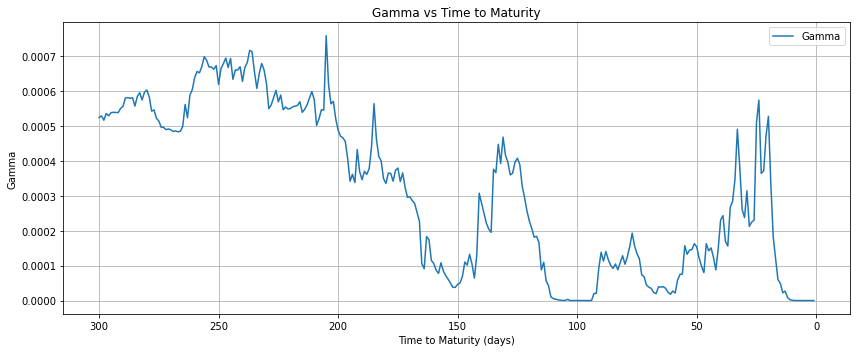

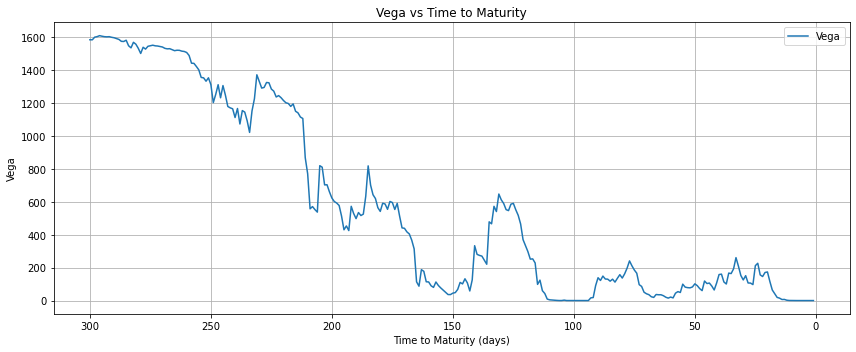

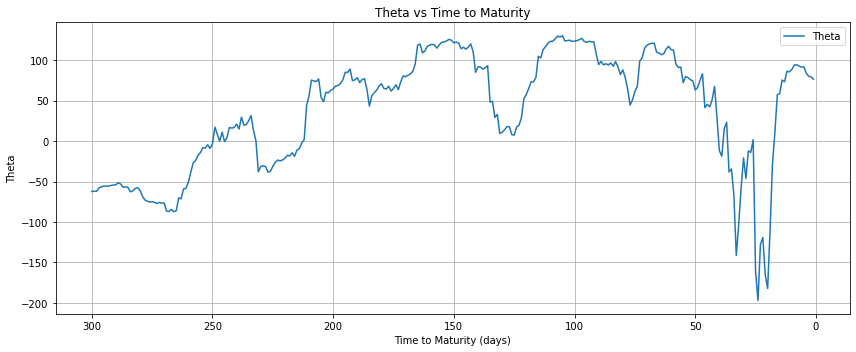

In [69]:

#---------------- All that needs to be decided -------------------------

# Define date range
sim_start = '2021-01-01'
sim_finish = '2028-09-28'


# Choose option type and parameters
Call_or_Put = "Call"
K = 3800
Time_to_maturity = 300
q = 0.04


# S&P 500 and 10-Year Treasury yield (interest rate) 
# Note: Decide on Economy
tickers = ['^GSPC', '^TNX']
data = yf.download(tickers, start=sim_start, end=sim_finish, auto_adjust=True)['Close']
data.rename(columns={'^GSPC': 'S', '^TNX': 'Rate'}, inplace=True)



#-------------------------End------------------------------------------







# --- Compute daily log returns and rolling volatility ---
data['S Daily return'] = data['S'].pct_change()
data['S Daily log return'] = np.log(data['S'] / data['S'].shift(1))
data['sigma'] = data['S Daily log return'].rolling(window=20).std() * np.sqrt(252) # KEY DIFFERENCE IS NOT USING AVERAGE I.E. NON CONSTANT

# --- Risk-free rate from 10Y yield, convert % to decimal ---
data['r'] = data['Rate'] / 100    # KEY DIFFERENCE IS NOT USING AVERAGE I.E. NON CONSTANT 

# --- Set constant dividend yield ---
data['q'] = q

# --- Final tidy up ---
data.drop(columns=['Rate'], inplace=True)
data.dropna(inplace=True)

# --- Ready to use ---
market_returns = data.copy()



# --- Option pricing loop ---
option_prices = []
deltas = []
gammas = []
vegas = []
thetas = []
T_values = []

for i, (index, row) in enumerate(market_returns.iterrows()):
    S = float(row['S'])
    sigma = float(row['sigma'])
    r = float(row['r'])
    q = float(row['q'])

    T_days_remaining = max(Time_to_maturity - i, 0)
    T = T_days_remaining / 252  # time in years

    if Call_or_Put == "Call":
        price, delta, gamma, vega, theta = CallOptionValue(S, K, r, sigma, T, q)
    elif Call_or_Put == "Put":
        price, delta, gamma, vega, theta = PutOptionValue(S, K, r, sigma, T, q)
    else:
        raise ValueError("Invalid option type. Use 'Call' or 'Put'.")

    option_prices.append(price)
    deltas.append(delta)
    gammas.append(gamma)
    vegas.append(vega)
    thetas.append(theta)
    T_values.append(T_days_remaining)

# --- Store results in DataFrame ---
market_returns[f'{Call_or_Put} Option Price (K={K})'] = option_prices
market_returns['Delta'] = deltas
market_returns['Gamma'] = gammas
market_returns['Vega'] = vegas
market_returns['Theta'] = thetas
market_returns['T (days)'] = T_values
market_returns.dropna(inplace=True)





# The bank plans to price and delta-hedge 
#the written options based on Black-Scholes formula.
# i.e we are always short

# Define position
 
initial_option_price = market_returns[f'{Call_or_Put} Option Price (K={K})'].iloc[0]  # we receive premium
    
market_returns['Index Investment ($)'] = market_returns['Delta'] * market_returns['S']  # short delta shares    
market_returns['Daily Gain from index move'] = market_returns['Index Investment ($)'].shift(1)*market_returns['S Daily return']
market_returns['Daily Gain from written option'] = -market_returns[f'{Call_or_Put} Option Price (K={K})'].diff()
market_returns['Daily Portfolio Gain'] = market_returns['Daily Gain from index move'] + market_returns['Daily Gain from written option']
market_returns['Cumulative Portfolio Gain'] = market_returns['Daily Portfolio Gain'].cumsum()

market_returns.fillna(0, inplace=True)
market_returns['Portfolio Value'] = market_returns['Cumulative Portfolio Gain'] + initial_option_price



market_returns['Cumulative Portfolio Return (%)'] = (
    market_returns['Cumulative Portfolio Gain'] / initial_option_price
) * 100


# --- Preview ---


market_returns[['S','S Daily return','sigma', 'r', 'q','T (days)', f'{Call_or_Put} Option Price (K={K})',
                'Delta', 'Index Investment ($)' , 'Daily Gain from index move', 'Daily Gain from written option', 'Daily Portfolio Gain', 'Cumulative Portfolio Gain',
               'Cumulative Portfolio Return (%)']]




plt.figure(figsize=(12, 5))
plt.plot(market_returns['T (days)'], market_returns['S'], label='Index price')
plt.xlabel('Time to Maturity (days)')
plt.ylabel('Index price')
plt.title('Index price vs Time to Maturity')
plt.gca().invert_xaxis()
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



plt.figure(figsize=(12, 5))
plt.plot(market_returns['T (days)'], market_returns['sigma'], label='Annualised Volatility')
plt.xlabel('Time to Maturity (days)')
plt.ylabel('Volatility (σ)')
plt.title('Volatility vs Time to Maturity')
plt.gca().invert_xaxis()
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()




plt.figure(figsize=(12, 5))
plt.plot(market_returns['T (days)'], market_returns[f'{Call_or_Put} Option Price (K={K})'], label=f'{Call_or_Put} Option Price (K={K})')
plt.xlabel('Time to Maturity (days)')
plt.ylabel(f'{Call_or_Put} Option Price (K={K})')
plt.title(f'{Call_or_Put} Option Price (K={K}) vs Time to Maturity')
plt.gca().invert_xaxis()
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


plt.figure(figsize=(12, 5))
plt.plot(market_returns['T (days)'], market_returns['Daily Gain from index move'], label='Index Move Gain', color='blue')
plt.plot(market_returns['T (days)'], market_returns['Daily Gain from written option'], label='Option Gain', color='red')
plt.title('Daily PnL Components vs Time to Maturity')
plt.xlabel('Time to Maturity (days)')
plt.ylabel('Gain ($)')
plt.legend()
plt.grid(True)
plt.gca().invert_xaxis()  # Optional: shows time progressing left to right
plt.tight_layout()
plt.show()






fig, ax1 = plt.subplots(figsize=(12, 5))

# Plot Portfolio Value on the primary y-axis
color1 = 'purple'
ax1.set_xlabel('Time to Maturity (days)')
ax1.set_ylabel('Portfolio Value ($)', color='black')
ax1.plot(market_returns['T (days)'], market_returns['Portfolio Value'], color=color1, label='Portfolio Value ($)')
ax1.tick_params(axis='y', labelcolor='black')
ax1.invert_xaxis()  # So time moves forward left to right
ax1.grid(True)

# Create secondary y-axis for cumulative return
ax2 = ax1.twinx()
color2 = 'purple'
ax2.set_ylabel('Cumulative Portfolio Return (%)', color='black')
ax2.plot(market_returns['T (days)'], market_returns['Cumulative Portfolio Return (%)'], color=color2, label='Cumulative Portfolio Return (%)')
ax2.tick_params(axis='y', labelcolor='black')

# Add title and layout
plt.title('Portfolio Value and Cumulative Return vs Time to Maturity')
fig.tight_layout()
plt.show()




plt.figure(figsize=(12, 5))
plt.plot(market_returns['T (days)'], market_returns['Delta'], label='Delta')
plt.xlabel('Time to Maturity (days)')
plt.ylabel('Delta')
plt.title('Delta vs Time to Maturity')
plt.gca().invert_xaxis()
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



plt.figure(figsize=(12, 5))
plt.plot(market_returns['T (days)'], market_returns['Gamma'], label='Gamma')
plt.xlabel('Time to Maturity (days)')
plt.ylabel('Gamma')
plt.title('Gamma vs Time to Maturity')
plt.gca().invert_xaxis()
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



plt.figure(figsize=(12, 5))
plt.plot(market_returns['T (days)'], market_returns['Vega'], label='Vega')
plt.xlabel('Time to Maturity (days)')
plt.ylabel('Vega')
plt.title('Vega vs Time to Maturity')
plt.gca().invert_xaxis()
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()




plt.figure(figsize=(12, 5))
plt.plot(market_returns['T (days)'], market_returns['Theta'], label='Theta')
plt.xlabel('Time to Maturity (days)')
plt.ylabel('Theta')
plt.title('Theta vs Time to Maturity')
plt.gca().invert_xaxis()
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



# Non-constant Volatility and Interest rate (reality) and Transaction fees violations 

[*********************100%***********************]  2 of 2 completed


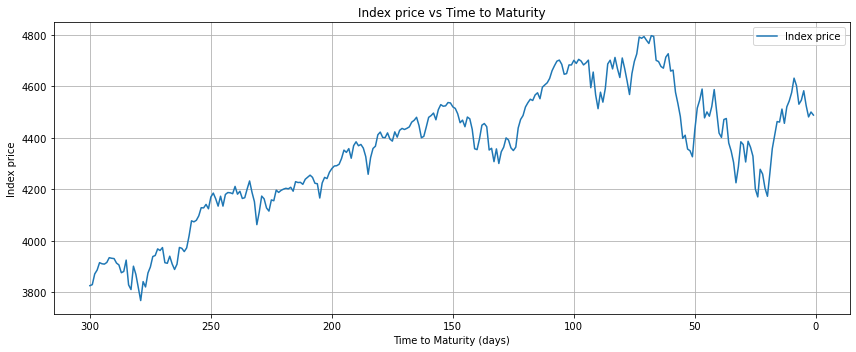

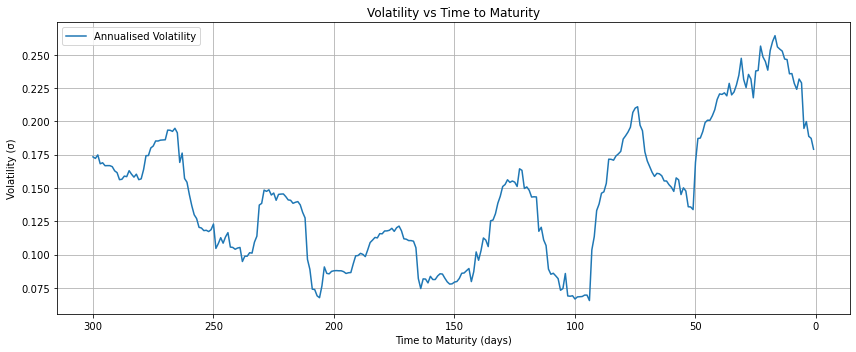

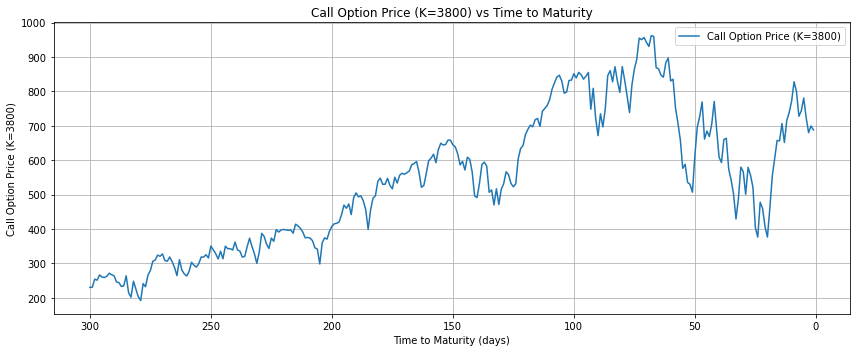

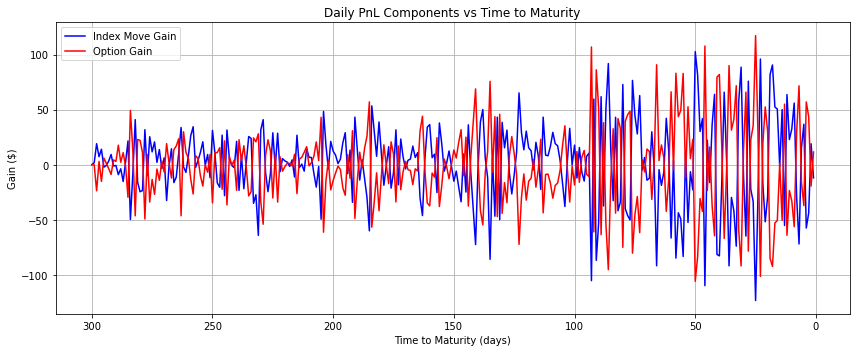

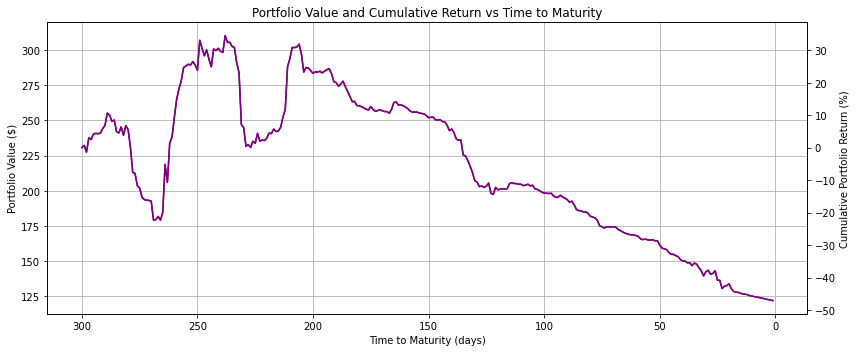

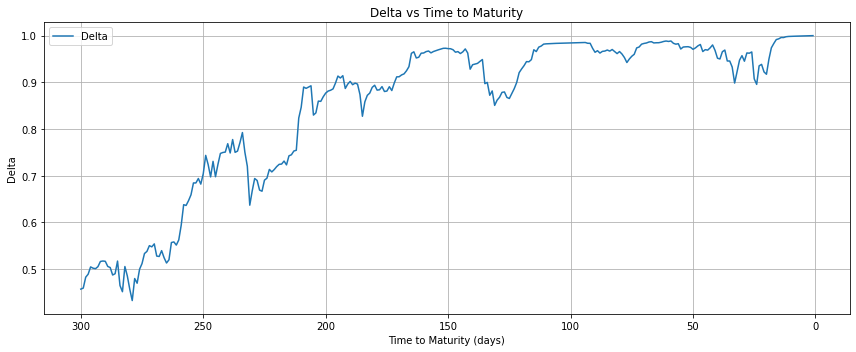

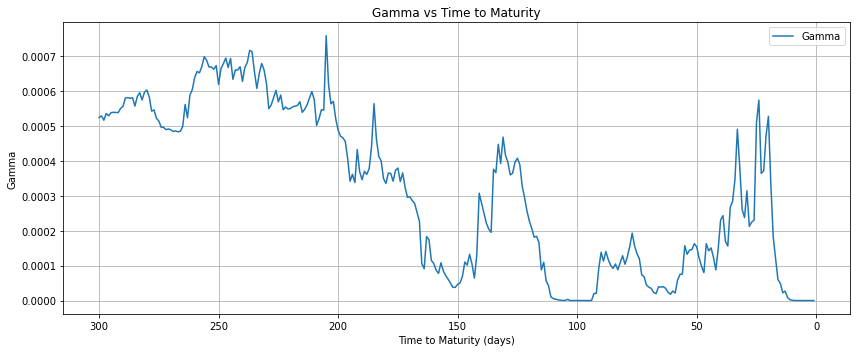

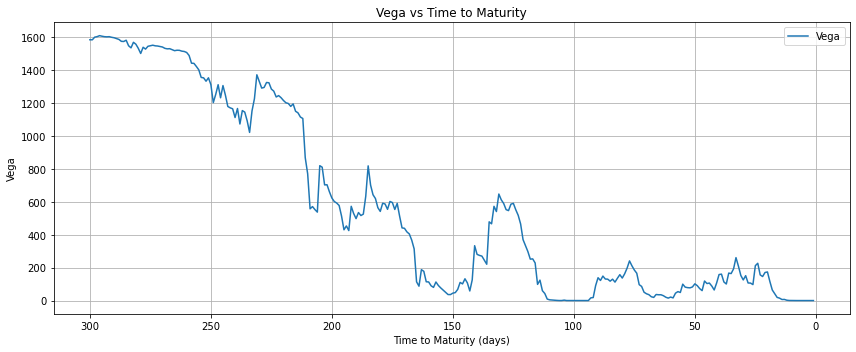

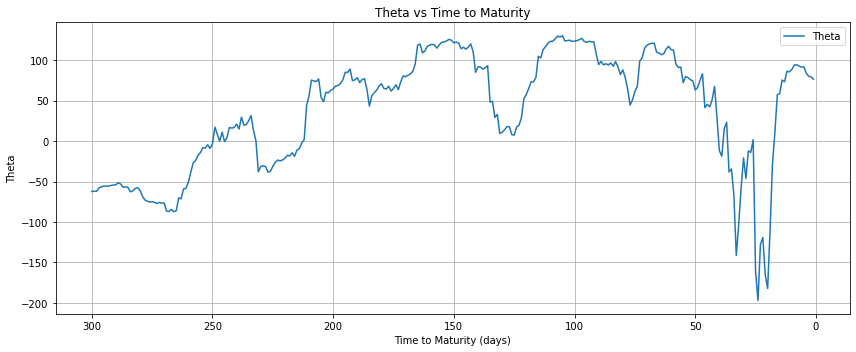

In [74]:

#---------------- All that needs to be decided -------------------------

# Define date range
sim_start = '2021-01-01'
sim_finish = '2028-09-28'


# Choose option type and parameters
Call_or_Put = "Call"
K = 3800
Time_to_maturity = 300
q = 0.04

# Transaction cost rate (e.g., 0.05%) this is pretty standard for institutional
transaction_cost_rate = 0.0005


# S&P 500 and 10-Year Treasury yield (interest rate) 
# Note: Decide on Economy
tickers = ['^GSPC', '^TNX']
data = yf.download(tickers, start=sim_start, end=sim_finish, auto_adjust=True)['Close']
data.rename(columns={'^GSPC': 'S', '^TNX': 'Rate'}, inplace=True)



#-------------------------End------------------------------------------







# --- Compute daily log returns and rolling volatility ---
data['S Daily return'] = data['S'].pct_change()
data['S Daily log return'] = np.log(data['S'] / data['S'].shift(1))
data['sigma'] = data['S Daily log return'].rolling(window=20).std() * np.sqrt(252) # KEY DIFFERENCE IS NOT USING AVERAGE I.E. NON CONSTANT

# --- Risk-free rate from 10Y yield, convert % to decimal ---
data['r'] = data['Rate'] / 100    # KEY DIFFERENCE IS NOT USING AVERAGE I.E. NON CONSTANT 

# --- Set constant dividend yield ---
data['q'] = q

# --- Final tidy up ---
data.drop(columns=['Rate'], inplace=True)
data.dropna(inplace=True)

# --- Ready to use ---
market_returns = data.copy()



# --- Option pricing loop ---
option_prices = []
deltas = []
gammas = []
vegas = []
thetas = []
T_values = []

for i, (index, row) in enumerate(market_returns.iterrows()):
    S = float(row['S'])
    sigma = float(row['sigma'])
    r = float(row['r'])
    q = float(row['q'])

    T_days_remaining = max(Time_to_maturity - i, 0)
    T = T_days_remaining / 252  # time in years

    if Call_or_Put == "Call":
        price, delta, gamma, vega, theta = CallOptionValue(S, K, r, sigma, T, q)
    elif Call_or_Put == "Put":
        price, delta, gamma, vega, theta = PutOptionValue(S, K, r, sigma, T, q)
    else:
        raise ValueError("Invalid option type. Use 'Call' or 'Put'.")

    option_prices.append(price)
    deltas.append(delta)
    gammas.append(gamma)
    vegas.append(vega)
    thetas.append(theta)
    T_values.append(T_days_remaining)

# --- Store results in DataFrame ---
market_returns[f'{Call_or_Put} Option Price (K={K})'] = option_prices
market_returns['Delta'] = deltas
market_returns['Gamma'] = gammas
market_returns['Vega'] = vegas
market_returns['Theta'] = thetas
market_returns['T (days)'] = T_values
market_returns.dropna(inplace=True)





# The bank plans to price and delta-hedge the written options based on Black-Scholes formula.
# i.e. we are always short the option.

# Define position
initial_option_price = market_returns[f'{Call_or_Put} Option Price (K={K})'].iloc[0]  # we receive premium

# Transaction cost rate (e.g., 0.25%)
transaction_cost_rate = 0.0025

# Set up base columns
market_returns['Index Investment ($)'] = market_returns['Delta'] * market_returns['S']  # short delta shares    
market_returns['Daily Gain from index move'] = market_returns['Index Investment ($)'].shift(1) * market_returns['S Daily return']
market_returns['Daily Gain from written option'] = -market_returns[f'{Call_or_Put} Option Price (K={K})'].diff()

# Calculate daily change in delta
market_returns['Delta Change'] = market_returns['Delta'].diff()
market_returns['Transaction Cost ($)'] = transaction_cost_rate * market_returns['S'] * market_returns['Delta Change'].abs()

# Fill NaN with 0 for first row
market_returns.fillna(0, inplace=True)

# Total daily gain/loss including transaction costs
market_returns['Daily Portfolio Gain'] = (
    market_returns['Daily Gain from index move']
    + market_returns['Daily Gain from written option']
    - market_returns['Transaction Cost ($)']
)

# Cumulative portfolio performance
market_returns['Cumulative Portfolio Gain'] = market_returns['Daily Portfolio Gain'].cumsum()
market_returns['Portfolio Value'] = market_returns['Cumulative Portfolio Gain'] + initial_option_price

market_returns['Cumulative Portfolio Return (%)'] = (
    market_returns['Cumulative Portfolio Gain'] / initial_option_price
) * 100


# --- Preview ---


market_returns[['S','S Daily return','sigma', 'r', 'q','T (days)', f'{Call_or_Put} Option Price (K={K})',
                'Delta', 'Index Investment ($)' , 'Daily Gain from index move', 'Daily Gain from written option', 'Daily Portfolio Gain', 'Cumulative Portfolio Gain',
               'Cumulative Portfolio Return (%)']]




plt.figure(figsize=(12, 5))
plt.plot(market_returns['T (days)'], market_returns['S'], label='Index price')
plt.xlabel('Time to Maturity (days)')
plt.ylabel('Index price')
plt.title('Index price vs Time to Maturity')
plt.gca().invert_xaxis()
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



plt.figure(figsize=(12, 5))
plt.plot(market_returns['T (days)'], market_returns['sigma'], label='Annualised Volatility')
plt.xlabel('Time to Maturity (days)')
plt.ylabel('Volatility (σ)')
plt.title('Volatility vs Time to Maturity')
plt.gca().invert_xaxis()
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()




plt.figure(figsize=(12, 5))
plt.plot(market_returns['T (days)'], market_returns[f'{Call_or_Put} Option Price (K={K})'], label=f'{Call_or_Put} Option Price (K={K})')
plt.xlabel('Time to Maturity (days)')
plt.ylabel(f'{Call_or_Put} Option Price (K={K})')
plt.title(f'{Call_or_Put} Option Price (K={K}) vs Time to Maturity')
plt.gca().invert_xaxis()
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


plt.figure(figsize=(12, 5))
plt.plot(market_returns['T (days)'], market_returns['Daily Gain from index move'], label='Index Move Gain', color='blue')
plt.plot(market_returns['T (days)'], market_returns['Daily Gain from written option'], label='Option Gain', color='red')
plt.title('Daily PnL Components vs Time to Maturity')
plt.xlabel('Time to Maturity (days)')
plt.ylabel('Gain ($)')
plt.legend()
plt.grid(True)
plt.gca().invert_xaxis()  # Optional: shows time progressing left to right
plt.tight_layout()
plt.show()






fig, ax1 = plt.subplots(figsize=(12, 5))

# Plot Portfolio Value on the primary y-axis
color1 = 'purple'
ax1.set_xlabel('Time to Maturity (days)')
ax1.set_ylabel('Portfolio Value ($)', color='black')
ax1.plot(market_returns['T (days)'], market_returns['Portfolio Value'], color=color1, label='Portfolio Value ($)')
ax1.tick_params(axis='y', labelcolor='black')
ax1.invert_xaxis()  # So time moves forward left to right
ax1.grid(True)

# Create secondary y-axis for cumulative return
ax2 = ax1.twinx()
color2 = 'purple'
ax2.set_ylabel('Cumulative Portfolio Return (%)', color='black')
ax2.plot(market_returns['T (days)'], market_returns['Cumulative Portfolio Return (%)'], color=color2, label='Cumulative Portfolio Return (%)')
ax2.tick_params(axis='y', labelcolor='black')

# Add title and layout
plt.title('Portfolio Value and Cumulative Return vs Time to Maturity')
fig.tight_layout()
plt.show()




plt.figure(figsize=(12, 5))
plt.plot(market_returns['T (days)'], market_returns['Delta'], label='Delta')
plt.xlabel('Time to Maturity (days)')
plt.ylabel('Delta')
plt.title('Delta vs Time to Maturity')
plt.gca().invert_xaxis()
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



plt.figure(figsize=(12, 5))
plt.plot(market_returns['T (days)'], market_returns['Gamma'], label='Gamma')
plt.xlabel('Time to Maturity (days)')
plt.ylabel('Gamma')
plt.title('Gamma vs Time to Maturity')
plt.gca().invert_xaxis()
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



plt.figure(figsize=(12, 5))
plt.plot(market_returns['T (days)'], market_returns['Vega'], label='Vega')
plt.xlabel('Time to Maturity (days)')
plt.ylabel('Vega')
plt.title('Vega vs Time to Maturity')
plt.gca().invert_xaxis()
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()




plt.figure(figsize=(12, 5))
plt.plot(market_returns['T (days)'], market_returns['Theta'], label='Theta')
plt.xlabel('Time to Maturity (days)')
plt.ylabel('Theta')
plt.title('Theta vs Time to Maturity')
plt.gca().invert_xaxis()
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# Non-constant Volatility and Interest rate (reality), Transaction fees, Costs of borrowing or short-selling violations 

[*********************100%***********************]  2 of 2 completed


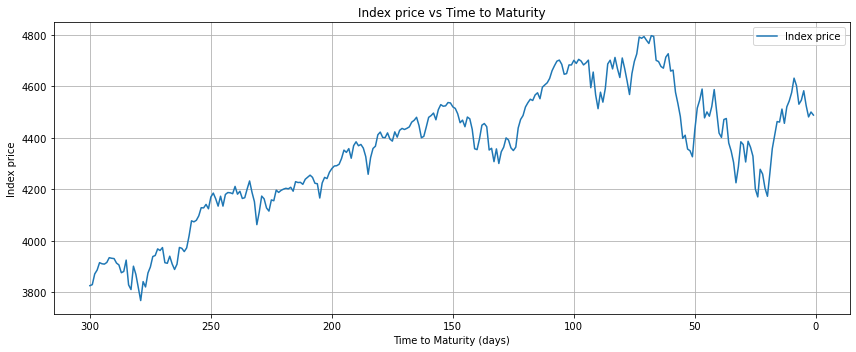

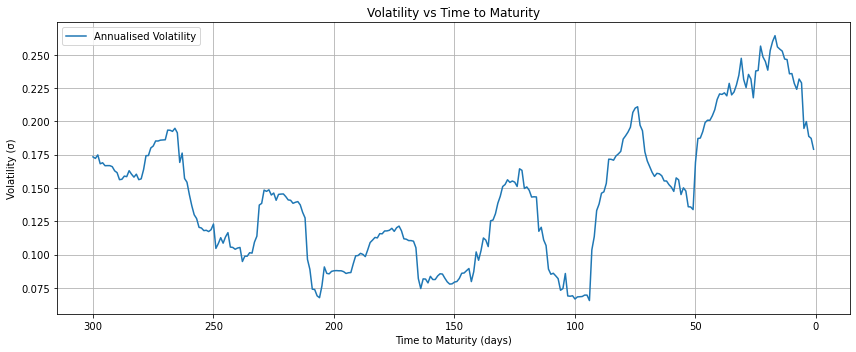

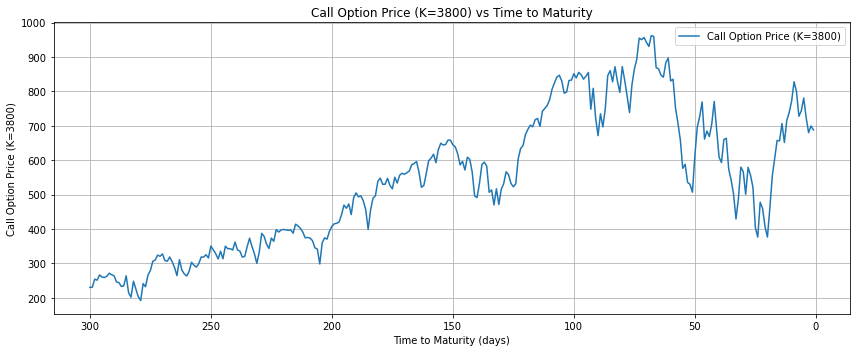

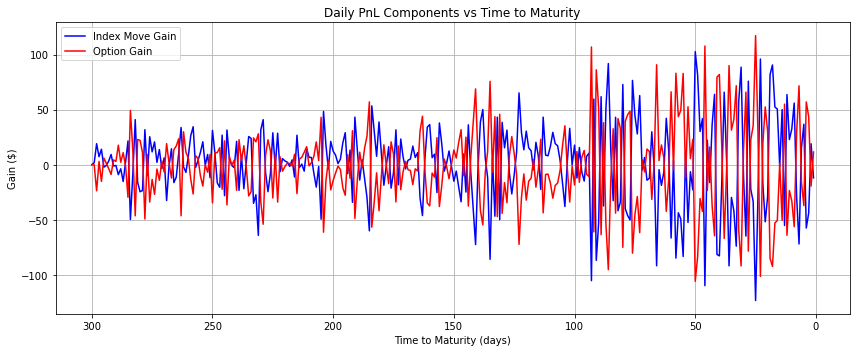

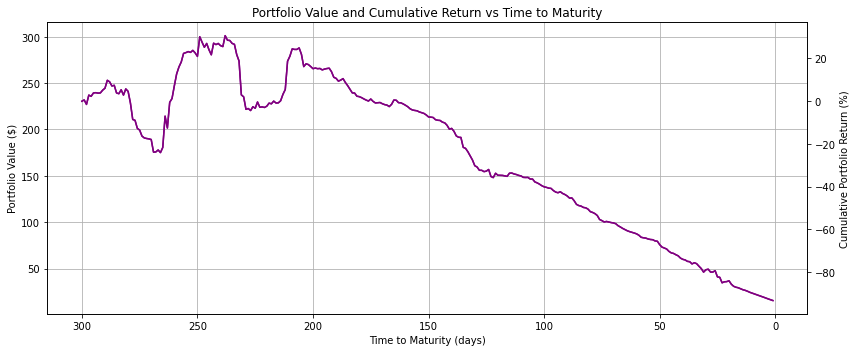

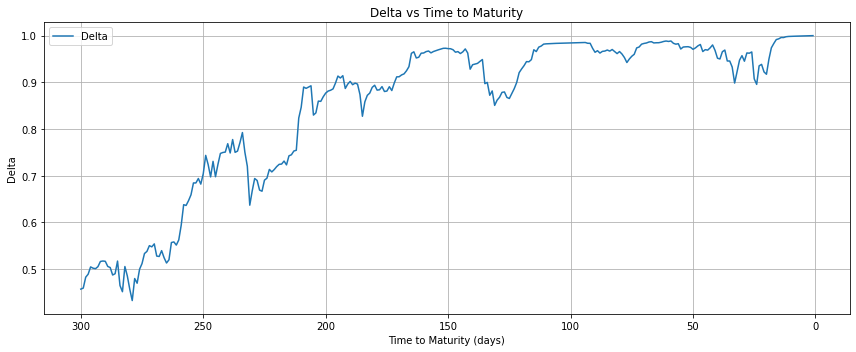

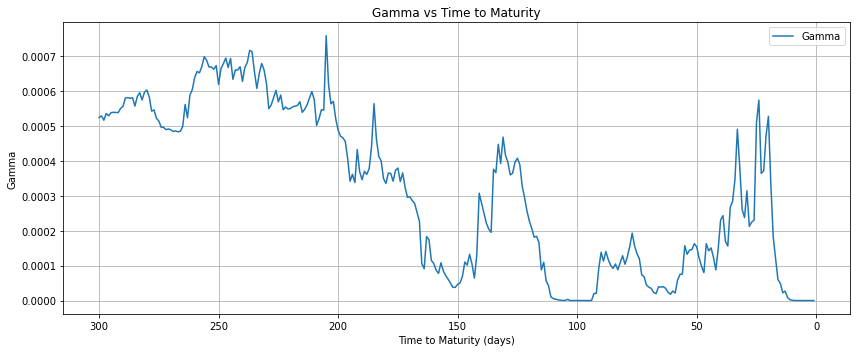

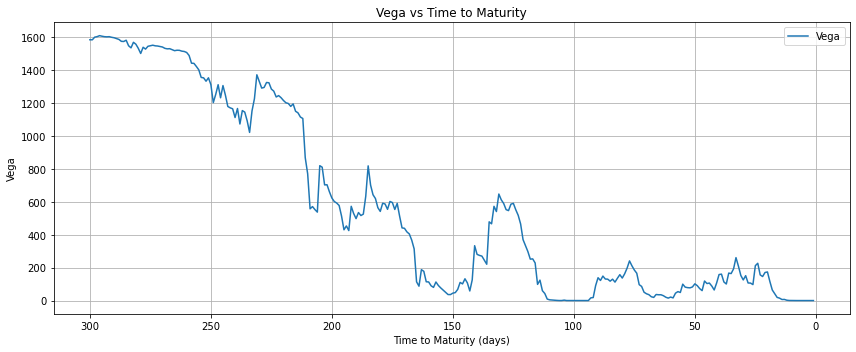

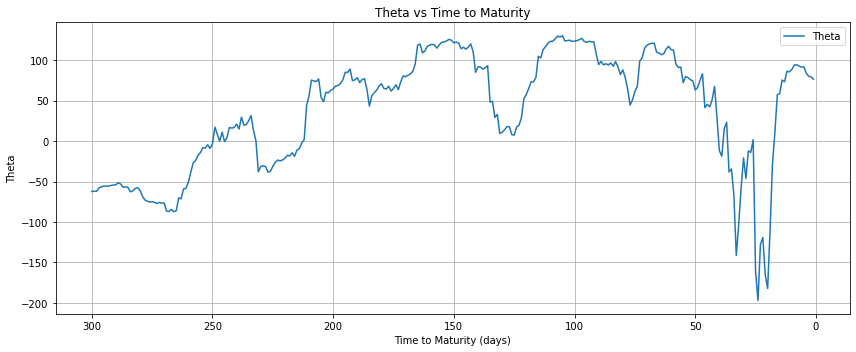

In [76]:

#---------------- All that needs to be decided -------------------------

# Define date range
sim_start = '2021-01-01'
sim_finish = '2028-09-28'


# Choose option type and parameters
Call_or_Put = "Call"
K = 3800
Time_to_maturity = 300
q = 0.04

transaction_cost_rate = 0.0005 # Transaction cost rate (e.g., 0.05%) this is pretty standard for institutional
borrow_fee_rate = 0.02       # 2% annualised borrow fee when short index
funding_rate = 0.03          # 3% annualised cost when long index



# S&P 500 and 10-Year Treasury yield (interest rate) 
# Note: Decide on Economy
tickers = ['^GSPC', '^TNX']
data = yf.download(tickers, start=sim_start, end=sim_finish, auto_adjust=True)['Close']
data.rename(columns={'^GSPC': 'S', '^TNX': 'Rate'}, inplace=True)



#-------------------------End------------------------------------------







# --- Compute daily log returns and rolling volatility ---
data['S Daily return'] = data['S'].pct_change()
data['S Daily log return'] = np.log(data['S'] / data['S'].shift(1))
data['sigma'] = data['S Daily log return'].rolling(window=20).std() * np.sqrt(252) # KEY DIFFERENCE IS NOT USING AVERAGE I.E. NON CONSTANT

# --- Risk-free rate from 10Y yield, convert % to decimal ---
data['r'] = data['Rate'] / 100    # KEY DIFFERENCE IS NOT USING AVERAGE I.E. NON CONSTANT 

# --- Set constant dividend yield ---
data['q'] = q

# --- Final tidy up ---
data.drop(columns=['Rate'], inplace=True)
data.dropna(inplace=True)

# --- Ready to use ---
market_returns = data.copy()



# --- Option pricing loop ---
option_prices = []
deltas = []
gammas = []
vegas = []
thetas = []
T_values = []

for i, (index, row) in enumerate(market_returns.iterrows()):
    S = float(row['S'])
    sigma = float(row['sigma'])
    r = float(row['r'])
    q = float(row['q'])

    T_days_remaining = max(Time_to_maturity - i, 0)
    T = T_days_remaining / 252  # time in years

    if Call_or_Put == "Call":
        price, delta, gamma, vega, theta = CallOptionValue(S, K, r, sigma, T, q)
    elif Call_or_Put == "Put":
        price, delta, gamma, vega, theta = PutOptionValue(S, K, r, sigma, T, q)
    else:
        raise ValueError("Invalid option type. Use 'Call' or 'Put'.")

    option_prices.append(price)
    deltas.append(delta)
    gammas.append(gamma)
    vegas.append(vega)
    thetas.append(theta)
    T_values.append(T_days_remaining)

# --- Store results in DataFrame ---
market_returns[f'{Call_or_Put} Option Price (K={K})'] = option_prices
market_returns['Delta'] = deltas
market_returns['Gamma'] = gammas
market_returns['Vega'] = vegas
market_returns['Theta'] = thetas
market_returns['T (days)'] = T_values
market_returns.dropna(inplace=True)





# The bank plans to price and delta-hedge the written options based on Black-Scholes formula.
# i.e. we are always short the option.

# Define position
initial_option_price = market_returns[f'{Call_or_Put} Option Price (K={K})'].iloc[0]  # we receive premium


# Set up base columns
market_returns['Index Investment ($)'] = market_returns['Delta'] * market_returns['S']  # short delta shares    
market_returns['Daily Gain from index move'] = market_returns['Index Investment ($)'].shift(1) * market_returns['S Daily return']
market_returns['Daily Gain from written option'] = -market_returns[f'{Call_or_Put} Option Price (K={K})'].diff()

# Calculate daily change in delta
market_returns['Delta Change'] = market_returns['Delta'].diff()
market_returns['Transaction Cost ($)'] = transaction_cost_rate * market_returns['S'] * market_returns['Delta Change'].abs()



# Daily rates
daily_borrow_fee = np.exp(borrow_fee_rate / 252) - 1
daily_funding_cost = np.exp(funding_rate / 252) - 1

# --- Apply cost depending on long/short position ---
market_returns['Funding Cost ($)'] = np.where(
    market_returns['Index Investment ($)'] > 0,  # Buying the index → borrowed funds
    -market_returns['Index Investment ($)'] * daily_funding_cost,
    -market_returns['Index Investment ($)'] * daily_borrow_fee  # Shorting the index → pay borrow fee
)



# Fill NaN with 0 for first row
market_returns.fillna(0, inplace=True)

# Total daily gain/loss including transaction costs
market_returns['Daily Portfolio Gain'] = (
    market_returns['Daily Gain from index move']
    + market_returns['Daily Gain from written option']
    - market_returns['Transaction Cost ($)'] +
    market_returns['Funding Cost ($)']
)

# Cumulative portfolio performance
market_returns['Cumulative Portfolio Gain'] = market_returns['Daily Portfolio Gain'].cumsum()
market_returns['Portfolio Value'] = market_returns['Cumulative Portfolio Gain'] + initial_option_price

market_returns['Cumulative Portfolio Return (%)'] = (
    market_returns['Cumulative Portfolio Gain'] / initial_option_price
) * 100


# --- Preview ---


market_returns[['S','S Daily return','sigma', 'r', 'q','T (days)', f'{Call_or_Put} Option Price (K={K})',
                'Delta', 'Index Investment ($)' , 'Daily Gain from index move', 'Daily Gain from written option', 'Daily Portfolio Gain', 'Cumulative Portfolio Gain',
               'Cumulative Portfolio Return (%)']]




plt.figure(figsize=(12, 5))
plt.plot(market_returns['T (days)'], market_returns['S'], label='Index price')
plt.xlabel('Time to Maturity (days)')
plt.ylabel('Index price')
plt.title('Index price vs Time to Maturity')
plt.gca().invert_xaxis()
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



plt.figure(figsize=(12, 5))
plt.plot(market_returns['T (days)'], market_returns['sigma'], label='Annualised Volatility')
plt.xlabel('Time to Maturity (days)')
plt.ylabel('Volatility (σ)')
plt.title('Volatility vs Time to Maturity')
plt.gca().invert_xaxis()
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()




plt.figure(figsize=(12, 5))
plt.plot(market_returns['T (days)'], market_returns[f'{Call_or_Put} Option Price (K={K})'], label=f'{Call_or_Put} Option Price (K={K})')
plt.xlabel('Time to Maturity (days)')
plt.ylabel(f'{Call_or_Put} Option Price (K={K})')
plt.title(f'{Call_or_Put} Option Price (K={K}) vs Time to Maturity')
plt.gca().invert_xaxis()
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


plt.figure(figsize=(12, 5))
plt.plot(market_returns['T (days)'], market_returns['Daily Gain from index move'], label='Index Move Gain', color='blue')
plt.plot(market_returns['T (days)'], market_returns['Daily Gain from written option'], label='Option Gain', color='red')
plt.title('Daily PnL Components vs Time to Maturity')
plt.xlabel('Time to Maturity (days)')
plt.ylabel('Gain ($)')
plt.legend()
plt.grid(True)
plt.gca().invert_xaxis()  # Optional: shows time progressing left to right
plt.tight_layout()
plt.show()






fig, ax1 = plt.subplots(figsize=(12, 5))

# Plot Portfolio Value on the primary y-axis
color1 = 'purple'
ax1.set_xlabel('Time to Maturity (days)')
ax1.set_ylabel('Portfolio Value ($)', color='black')
ax1.plot(market_returns['T (days)'], market_returns['Portfolio Value'], color=color1, label='Portfolio Value ($)')
ax1.tick_params(axis='y', labelcolor='black')
ax1.invert_xaxis()  # So time moves forward left to right
ax1.grid(True)

# Create secondary y-axis for cumulative return
ax2 = ax1.twinx()
color2 = 'purple'
ax2.set_ylabel('Cumulative Portfolio Return (%)', color='black')
ax2.plot(market_returns['T (days)'], market_returns['Cumulative Portfolio Return (%)'], color=color2, label='Cumulative Portfolio Return (%)')
ax2.tick_params(axis='y', labelcolor='black')

# Add title and layout
plt.title('Portfolio Value and Cumulative Return vs Time to Maturity')
fig.tight_layout()
plt.show()




plt.figure(figsize=(12, 5))
plt.plot(market_returns['T (days)'], market_returns['Delta'], label='Delta')
plt.xlabel('Time to Maturity (days)')
plt.ylabel('Delta')
plt.title('Delta vs Time to Maturity')
plt.gca().invert_xaxis()
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



plt.figure(figsize=(12, 5))
plt.plot(market_returns['T (days)'], market_returns['Gamma'], label='Gamma')
plt.xlabel('Time to Maturity (days)')
plt.ylabel('Gamma')
plt.title('Gamma vs Time to Maturity')
plt.gca().invert_xaxis()
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



plt.figure(figsize=(12, 5))
plt.plot(market_returns['T (days)'], market_returns['Vega'], label='Vega')
plt.xlabel('Time to Maturity (days)')
plt.ylabel('Vega')
plt.title('Vega vs Time to Maturity')
plt.gca().invert_xaxis()
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()




plt.figure(figsize=(12, 5))
plt.plot(market_returns['T (days)'], market_returns['Theta'], label='Theta')
plt.xlabel('Time to Maturity (days)')
plt.ylabel('Theta')
plt.title('Theta vs Time to Maturity')
plt.gca().invert_xaxis()
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# Non-constant Volatility and Interest rate (reality), Transaction fees, Costs of borrowing or short-selling, Infrequent trading violations 

[*********************100%***********************]  2 of 2 completed


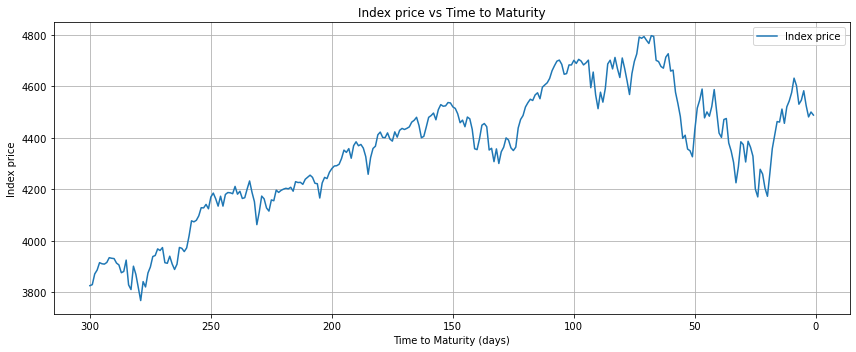

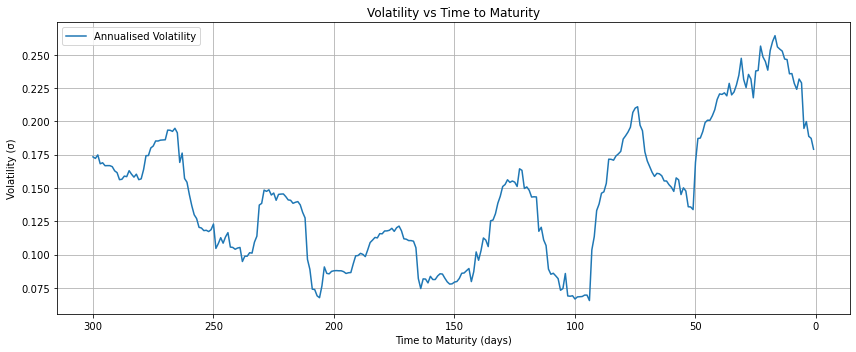

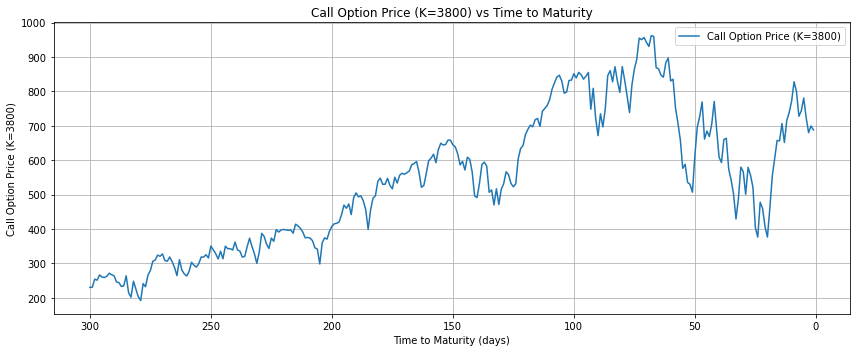

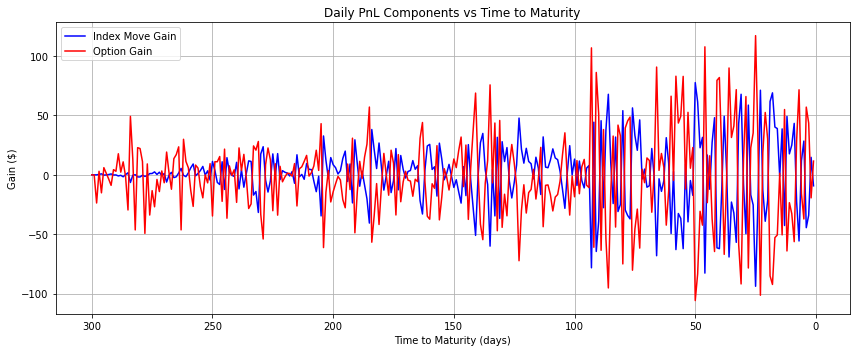

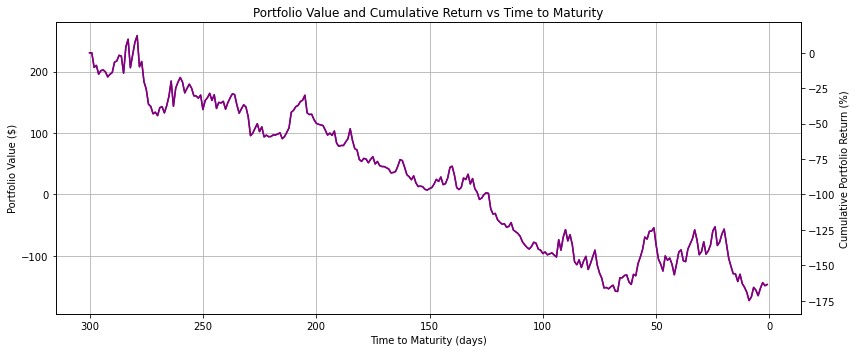

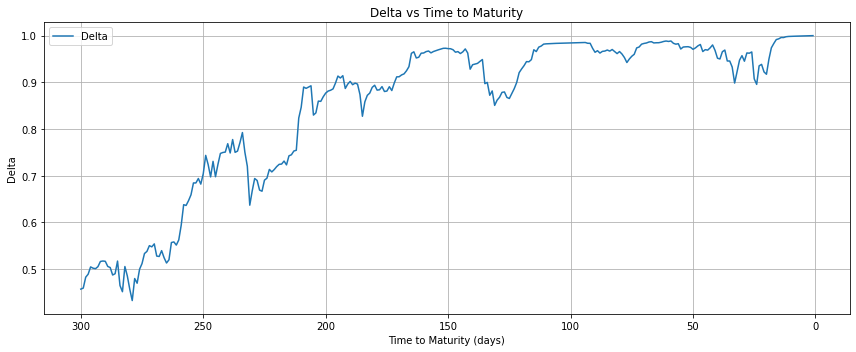

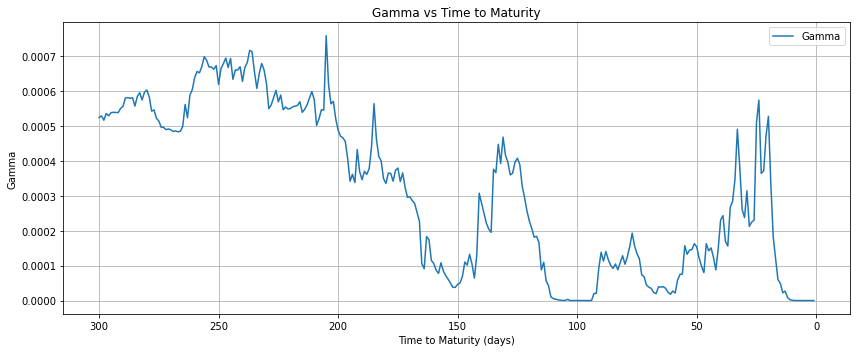

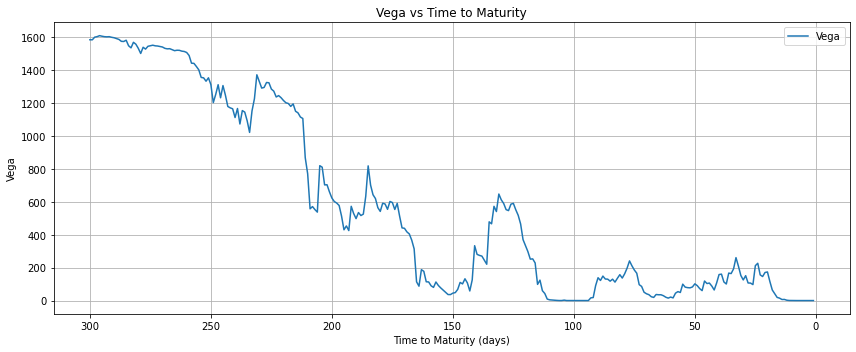

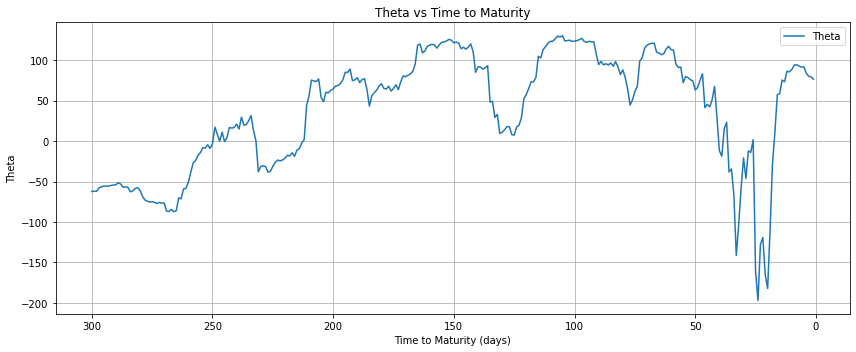

In [77]:
#---------------- All that needs to be decided -------------------------

# Define date range
sim_start = '2021-01-01'
sim_finish = '2028-09-28'

# Choose option type and parameters
Call_or_Put = "Call"
K = 3800
Time_to_maturity = 300
q = 0.04

transaction_cost_rate = 0.0005  # 0.05%
borrow_fee_rate = 0.02          # 2% annualised
funding_rate = 0.03             # 3% annualised
hedge_fill_probability = 0.8    # 80% chance hedge is filled

# S&P 500 and 10-Year Treasury yield
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

tickers = ['^GSPC', '^TNX']
data = yf.download(tickers, start=sim_start, end=sim_finish, auto_adjust=True)['Close']
data.rename(columns={'^GSPC': 'S', '^TNX': 'Rate'}, inplace=True)

# --- Compute daily returns and volatility ---
data['S Daily return'] = data['S'].pct_change()
data['S Daily log return'] = np.log(data['S'] / data['S'].shift(1))
data['sigma'] = data['S Daily log return'].rolling(window=20).std() * np.sqrt(252)
data['r'] = data['Rate'] / 100

# --- Set dividend yield and clean ---
data['q'] = q
data.drop(columns=['Rate'], inplace=True)
data.dropna(inplace=True)
market_returns = data.copy()

# --- Option pricing ---
option_prices, deltas, gammas, vegas, thetas, T_values = [], [], [], [], [], []

for i, (index, row) in enumerate(market_returns.iterrows()):
    S, sigma, r, q = float(row['S']), float(row['sigma']), float(row['r']), float(row['q'])
    T_days_remaining = max(Time_to_maturity - i, 0)
    T = T_days_remaining / 252

    if Call_or_Put == "Call":
        price, delta, gamma, vega, theta = CallOptionValue(S, K, r, sigma, T, q)
    else:
        price, delta, gamma, vega, theta = PutOptionValue(S, K, r, sigma, T, q)

    option_prices.append(price)
    deltas.append(delta)
    gammas.append(gamma)
    vegas.append(vega)
    thetas.append(theta)
    T_values.append(T_days_remaining)

market_returns[f'{Call_or_Put} Option Price (K={K})'] = option_prices
market_returns['Delta'] = deltas
market_returns['Gamma'] = gammas
market_returns['Vega'] = vegas
market_returns['Theta'] = thetas
market_returns['T (days)'] = T_values
market_returns.dropna(inplace=True)

# --- Infrequent trading simulation ---
np.random.seed(42)
market_returns['Hedge Executed'] = np.random.rand(len(market_returns)) < hedge_fill_probability
market_returns['Delta Change'] = market_returns['Delta'].diff()
market_returns['Effective Delta Change'] = market_returns['Delta Change'] * market_returns['Hedge Executed']
market_returns['Effective Delta'] = market_returns['Effective Delta Change'].cumsum().fillna(0)

# --- Hedging and cost calculation ---
initial_option_price = market_returns[f'{Call_or_Put} Option Price (K={K})'].iloc[0]
market_returns['Index Investment ($)'] = market_returns['Effective Delta'] * market_returns['S']
market_returns['Daily Gain from index move'] = market_returns['Index Investment ($)'].shift(1) * market_returns['S Daily return']
market_returns['Daily Gain from written option'] = -market_returns[f'{Call_or_Put} Option Price (K={K})'].diff()
market_returns['Transaction Cost ($)'] = transaction_cost_rate * market_returns['S'] * market_returns['Effective Delta Change'].abs()

daily_borrow_fee = np.exp(borrow_fee_rate / 252) - 1
daily_funding_cost = np.exp(funding_rate / 252) - 1

market_returns['Funding Cost ($)'] = np.where(
    market_returns['Index Investment ($)'] > 0,
    -market_returns['Index Investment ($)'] * daily_funding_cost,
    -market_returns['Index Investment ($)'] * daily_borrow_fee
)

market_returns.fillna(0, inplace=True)
market_returns['Daily Portfolio Gain'] = (
    market_returns['Daily Gain from index move']
    + market_returns['Daily Gain from written option']
    - market_returns['Transaction Cost ($)']
    + market_returns['Funding Cost ($)']
)
market_returns['Cumulative Portfolio Gain'] = market_returns['Daily Portfolio Gain'].cumsum()
market_returns['Portfolio Value'] = market_returns['Cumulative Portfolio Gain'] + initial_option_price
market_returns['Cumulative Portfolio Return (%)'] = (
    market_returns['Cumulative Portfolio Gain'] / initial_option_price
) * 100



# --- Preview ---


market_returns[['S','S Daily return','sigma', 'r', 'q','T (days)', f'{Call_or_Put} Option Price (K={K})',
                'Delta', 'Index Investment ($)' , 'Daily Gain from index move', 'Daily Gain from written option', 'Daily Portfolio Gain', 'Cumulative Portfolio Gain',
               'Cumulative Portfolio Return (%)']]




plt.figure(figsize=(12, 5))
plt.plot(market_returns['T (days)'], market_returns['S'], label='Index price')
plt.xlabel('Time to Maturity (days)')
plt.ylabel('Index price')
plt.title('Index price vs Time to Maturity')
plt.gca().invert_xaxis()
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



plt.figure(figsize=(12, 5))
plt.plot(market_returns['T (days)'], market_returns['sigma'], label='Annualised Volatility')
plt.xlabel('Time to Maturity (days)')
plt.ylabel('Volatility (σ)')
plt.title('Volatility vs Time to Maturity')
plt.gca().invert_xaxis()
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()




plt.figure(figsize=(12, 5))
plt.plot(market_returns['T (days)'], market_returns[f'{Call_or_Put} Option Price (K={K})'], label=f'{Call_or_Put} Option Price (K={K})')
plt.xlabel('Time to Maturity (days)')
plt.ylabel(f'{Call_or_Put} Option Price (K={K})')
plt.title(f'{Call_or_Put} Option Price (K={K}) vs Time to Maturity')
plt.gca().invert_xaxis()
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


plt.figure(figsize=(12, 5))
plt.plot(market_returns['T (days)'], market_returns['Daily Gain from index move'], label='Index Move Gain', color='blue')
plt.plot(market_returns['T (days)'], market_returns['Daily Gain from written option'], label='Option Gain', color='red')
plt.title('Daily PnL Components vs Time to Maturity')
plt.xlabel('Time to Maturity (days)')
plt.ylabel('Gain ($)')
plt.legend()
plt.grid(True)
plt.gca().invert_xaxis()  # Optional: shows time progressing left to right
plt.tight_layout()
plt.show()






fig, ax1 = plt.subplots(figsize=(12, 5))

# Plot Portfolio Value on the primary y-axis
color1 = 'purple'
ax1.set_xlabel('Time to Maturity (days)')
ax1.set_ylabel('Portfolio Value ($)', color='black')
ax1.plot(market_returns['T (days)'], market_returns['Portfolio Value'], color=color1, label='Portfolio Value ($)')
ax1.tick_params(axis='y', labelcolor='black')
ax1.invert_xaxis()  # So time moves forward left to right
ax1.grid(True)

# Create secondary y-axis for cumulative return
ax2 = ax1.twinx()
color2 = 'purple'
ax2.set_ylabel('Cumulative Portfolio Return (%)', color='black')
ax2.plot(market_returns['T (days)'], market_returns['Cumulative Portfolio Return (%)'], color=color2, label='Cumulative Portfolio Return (%)')
ax2.tick_params(axis='y', labelcolor='black')

# Add title and layout
plt.title('Portfolio Value and Cumulative Return vs Time to Maturity')
fig.tight_layout()
plt.show()




plt.figure(figsize=(12, 5))
plt.plot(market_returns['T (days)'], market_returns['Delta'], label='Delta')
plt.xlabel('Time to Maturity (days)')
plt.ylabel('Delta')
plt.title('Delta vs Time to Maturity')
plt.gca().invert_xaxis()
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



plt.figure(figsize=(12, 5))
plt.plot(market_returns['T (days)'], market_returns['Gamma'], label='Gamma')
plt.xlabel('Time to Maturity (days)')
plt.ylabel('Gamma')
plt.title('Gamma vs Time to Maturity')
plt.gca().invert_xaxis()
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



plt.figure(figsize=(12, 5))
plt.plot(market_returns['T (days)'], market_returns['Vega'], label='Vega')
plt.xlabel('Time to Maturity (days)')
plt.ylabel('Vega')
plt.title('Vega vs Time to Maturity')
plt.gca().invert_xaxis()
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()




plt.figure(figsize=(12, 5))
plt.plot(market_returns['T (days)'], market_returns['Theta'], label='Theta')
plt.xlabel('Time to Maturity (days)')
plt.ylabel('Theta')
plt.title('Theta vs Time to Maturity')
plt.gca().invert_xaxis()
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
